In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

In [2]:
import regressor
import utils

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Read data

In [4]:
metadata = pd.read_csv('../data/plasticc/plasticc_train_metadata.csv.gz')
data = pd.read_csv('../data/plasticc/plasticc_train_lightcurves.csv.gz')

data = data[data.detected_bool == 1]

In [5]:
metadata.head()

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,...,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,...,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,...,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,...,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,...,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data.head()

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [7]:
object_ids = np.unique(data.object_id)

In [8]:
passband2name = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
passband2lam  = {0: np.log10(3751.36), 1: np.log10(4741.64), 2: np.log10(6173.23), 
                 3: np.log10(7501.62), 4: np.log10(8679.19), 5: np.log10(9711.53)}

In [9]:
data[data['object_id'] == 745]

,object_id,mjd,passband,flux,flux_err,detected_bool
1157,745,60125.4094,2,220.795212,1.492162,1
1158,745,60125.4171,1,192.244293,1.432564,1
1159,745,60125.4248,3,203.250702,1.862000,1
1160,745,60125.4357,4,183.633118,2.818825,1
1161,745,60125.4448,5,141.513290,11.663839,1
...,...,...,...,...,...,...
1243,745,60237.2827,3,14.269365,1.747840,1
1246,745,60240.0698,2,7.153900,1.308041,1
1248,745,60240.0853,3,12.163086,1.697149,1
1251,745,60249.0813,2,8.373236,0.656900,1


# Visual analysis

In [10]:
def get_object(data, object_id):
    anobject = data[data.object_id == object_id]
    return anobject

In [11]:
def get_passband(anobject, passband):
    light_curve = anobject[anobject.passband == passband]
    return light_curve

In [12]:
def add_log_lam(anobject):
    passbands = anobject.passband.values
    log_lam = [passband2lam[i] for i in passbands]
    anobject['log_lam'] = log_lam
    return anobject

In [13]:
def create_approx_object(anobject, n=1000):
    mjd = anobject['mjd'].values
    dfs = []
    for passband in range(6):
        df = pd.DataFrame()
        df['mjd'] = np.linspace(mjd.min(), mjd.max(), n)
        df['object_id'] = 0
        df['passband'] = passband
        df['flux'] = 0
        df['flux_err'] = 0
        df['detected_bool'] = 1
        dfs.append(df)
    new_object = pd.concat(dfs, axis=0)
    new_object = add_log_lam(new_object)
    return new_object

In [14]:
def is_good(anobject):
    good = 1
    
    # remove all objects with negative flux values
    if anobject['flux'].values.min() < 0:
        good = 0
    
    # keep only objects with at least 10 observations in at least 3 passbands
    count = 0
    for passband in range(6):
        if len(get_passband(anobject, passband)) < 10:
            count += 1
    if count > 3:
        good = 0
        
    # keep only objects without large breaks in observations
    anobject = anobject.sort_values('mjd')
    mjd = anobject['mjd'].values
    if np.diff(mjd, 1).max() > 50:
        good = 0
    
    return good

In [15]:
def plot_light_curves(anobject, title=""):
    anobject = anobject.sort_values('mjd')
    plt.figure(figsize=(9, 4))
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=0.5)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, label=passband2name[passband], linewidth=1)
    plt.xlabel('Modified Julian Date', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)

In [16]:
def flux_not_negativ(anobject):
    anobject_new = anobject.copy()
    anobject_new['flux'] = np.where(anobject_new['flux'] < 0, 0, anobject_new['flux'])
    return anobject_new

34299


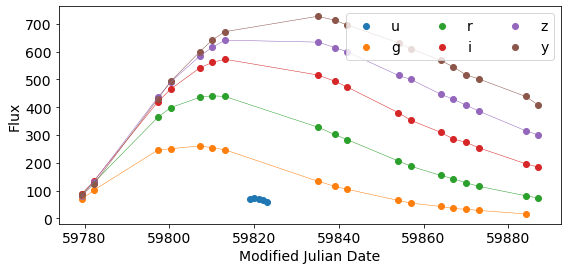

43812


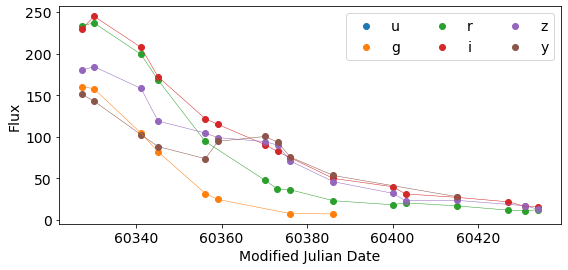

70046


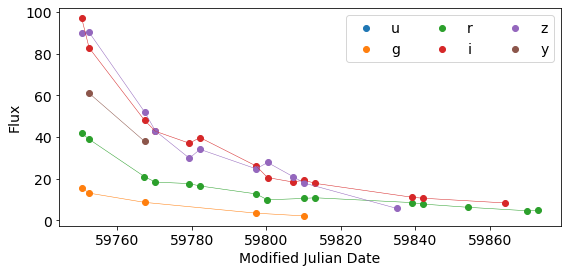

84716


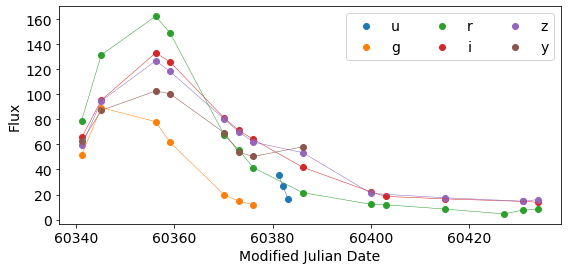

131629


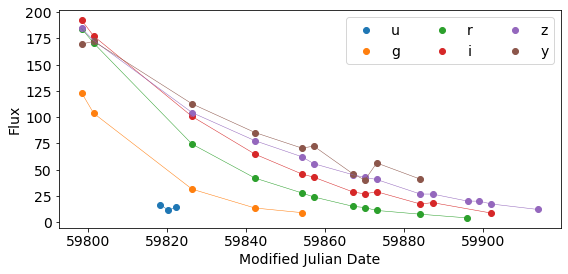

169315


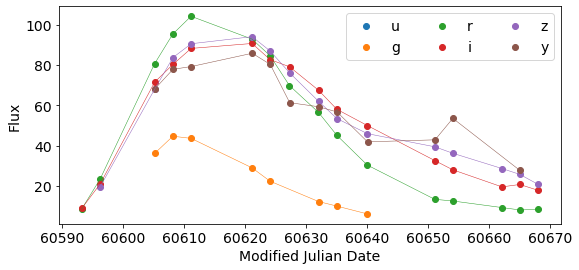

229855


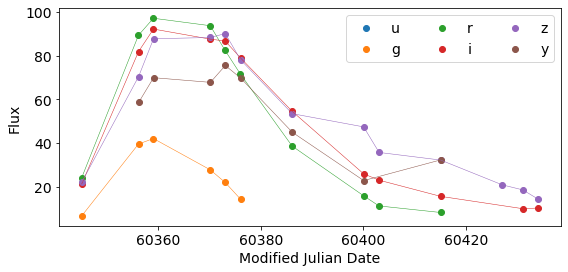

251430


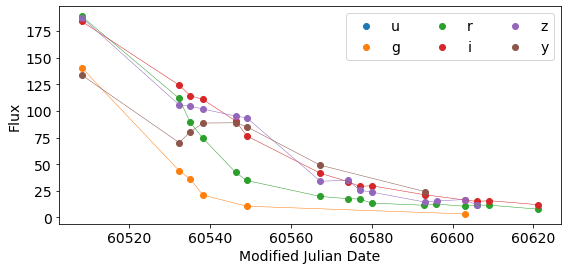

282714


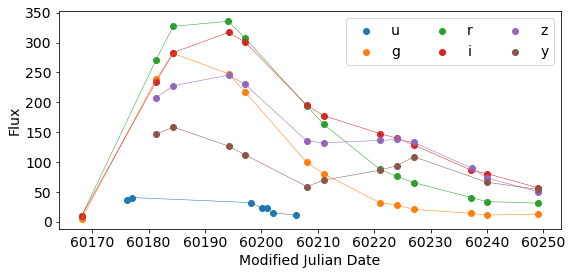

290682


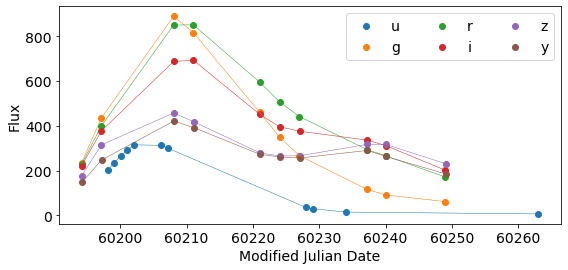

316306


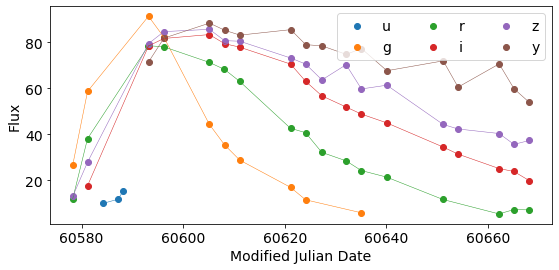

In [17]:
for i in object_ids[::50]:
    anobject = get_object(data, i)
    
    if not is_good(anobject): continue
    print(i)
    
    plot_light_curves(anobject)
    plt.show()

# One object test Test

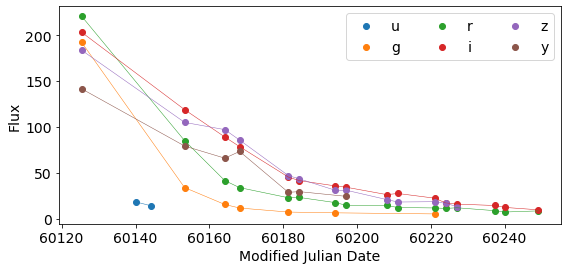

In [18]:
anobject = get_object(data, 745)
anobject = add_log_lam(anobject)

plot_light_curves(anobject)
plt.savefig('light_curve_34299.pdf', format='pdf')

In [19]:
MODEL = "GP"

In [20]:
import time


timer = time.time()

In [21]:
# train / test split
from sklearn.model_selection import train_test_split
anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)

X_train = anobject_train[['mjd', 'log_lam']].values
X_test = anobject_test[['mjd', 'log_lam']].values

y_train = anobject_train['flux'].values
y_test  = anobject_test['flux'].values

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

# fit a regression model to approximate light curves
if MODEL == "XGB":
    from xgboost import XGBRegressor
    reg = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, objective='reg:squarederror')
elif MODEL == "NN":
    reg = regressor.FitNNRegressor(n_hidden=300, n_epochs=200, batch_size=1, lr=0.01, lam=1., optimizer='RMSprop')
elif MODEL == "Linear":
    from sklearn.linear_model import LinearRegression
    reg = LinearRegression()
elif MODEL == "GP":
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, WhiteKernel, ConstantKernel as C
    kernel = C(1.0) * RBF([1.0, 1.0]) + WhiteKernel()
    reg = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=5, optimizer="fmin_l_bfgs_b", random_state=42)

reg.fit(X_train_ss, y_train)

# predict flux for unseen observations
anobject_test_pred = anobject_test.copy()
anobject_test_pred['flux'] = reg.predict(X_test_ss)

# predict flux for known observations
anobject_train_pred = anobject_train.copy()
anobject_train_pred['flux'] = reg.predict(X_train_ss)

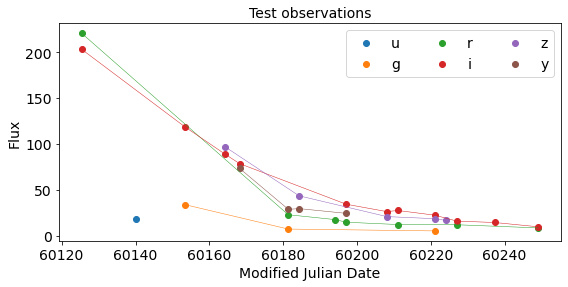

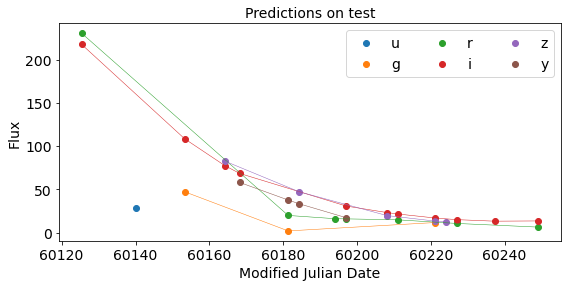

In [22]:
plot_light_curves(anobject_test, "Test observations")
plot_light_curves(anobject_test_pred, "Predictions on test")

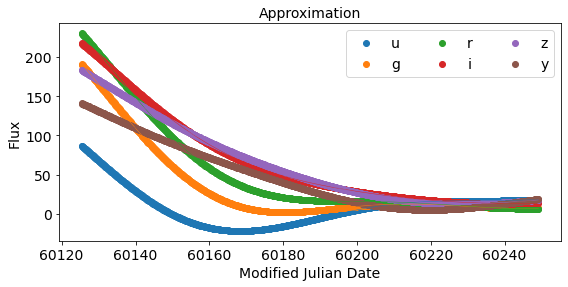

In [23]:
approx_object = create_approx_object(anobject)
X = approx_object[['mjd', 'log_lam']].values
X_ss = ss.transform(X)
approx_object['flux'] = reg.predict(X_ss)
plot_light_curves(approx_object, "Approximation")
plt.savefig('approx_light_curve_34299.pdf', format='pdf')

In [24]:
# calculate quality metrics
[rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                                      anobject_test_pred['flux'].values)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)
print("Work sec: %f" % (time.time() - timer))

RMSE:  7.513820111756014
MAE:  6.086585753909614
RSE:  0.14353957808976947
RAE:  0.1646043060327647
MAPE:  23.24095341146365
Work sec: 1.128657


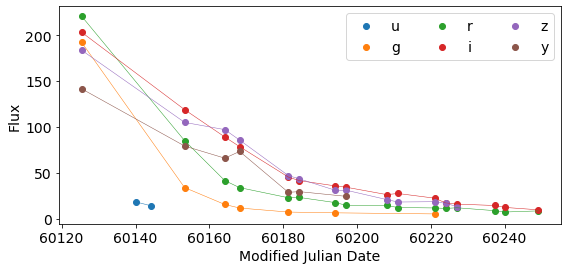

In [25]:
anobject = get_object(data, 745)#34299
anobject = add_log_lam(anobject)

plot_light_curves(anobject)
plt.savefig('light_curve_34299_2.pdf', format='pdf')

# Test on many objects

In [ ]:
report = pd.DataFrame(columns=["ID", 'RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])

for i in object_ids: 
    
    # get an object
    anobject = get_object(data, i)
    anobject = add_log_lam(anobject)
    
    if not is_good(anobject): continue
    
    print("Object ", i, " with ", len(anobject), " observations")
    
    # train / test split
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)
    
    X_train = anobject_train[['mjd', 'log_lam']].values
    X_test  = anobject_test[['mjd', 'log_lam']].values

    y_train = anobject_train['flux'].values
    y_test  = anobject_test['flux'].values

    from sklearn.preprocessing import StandardScaler
    ss = StandardScaler()
    X_train_ss = ss.fit_transform(X_train)
    X_test_ss = ss.transform(X_test)

    # fit a regression model to approximate light curves
    if MODEL == "XGB":
        from xgboost import XGBRegressor
        reg = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, objective='reg:squarederror')
    elif MODEL == "NN":
        reg = regressor.FitNNRegressor(n_hidden=100, n_epochs=100, batch_size=1, lr=0.01, lam=0.01, optimizer='Adam')
    elif MODEL == "Linear":
        from sklearn.linear_model import LinearRegression
        reg = LinearRegression()
    elif MODEL == "GP":
        from sklearn.gaussian_process import GaussianProcessRegressor
        from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, WhiteKernel, ConstantKernel as C
        kernel = C(1.0) * RBF([1.0, 1.0]) + WhiteKernel()
        reg = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=0, optimizer="fmin_l_bfgs_b", random_state=42)

    reg.fit(X_train_ss, y_train)

    
    # predict flux for unseen observations
    anobject_test_pred = anobject_test.copy()
    anobject_test_pred['flux'] = reg.predict(X_test_ss)
    
    metrics = utils.regression_quality_metrics_report(anobject_test['flux'].values, anobject_test_pred['flux'].values)
    report.loc[len(report), :] = [i] + list(metrics)
    

In [ ]:
np.round(report.mean(), 2)

In [ ]:
report